In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
f=pd.read_csv("20_years_data.csv")
df=pd.DataFrame(f,index = [x for x in range (0,f.shape[0])])
df = df[np.isfinite(df['PX_CLOSE_1D'])]
df=df.drop("BEST_DIV_YLD",axis=1)
df=pd.DataFrame(df,index = [x for x in range (0,df.shape[0])])
df=df.dropna(how='any')
new_index=[x for x in range (0,len(df))]
df['index']=df.index
print (df.isnull().sum())
print (df.head(5))

Date                    0
PX_LOW                  0
PX_HIGH                 0
PX_VOLUME               0
PX_OPEN                 0
PX_CLOSE_1D             0
BEST_PE_RATIO           0
CUR_MKT_CAP             0
BETA_ADJ_OVERRIDABLE    0
index                   0
dtype: int64
     Date  PX_LOW  PX_HIGH    PX_VOLUME  PX_OPEN  PX_CLOSE_1D  BEST_PE_RATIO  \
0  1/2/97  729.55   742.81  374804416.0   740.74       740.74        15.7963   
1  1/3/97  737.01   748.24  350120512.0   737.01       737.01        16.0770   
2  1/6/97  743.82   753.31  417856896.0   748.03       748.03        16.0817   
3  1/7/97  742.18   753.26  407369216.0   747.65       747.65        16.2128   
4  1/8/97  747.71   755.72  409502016.0   753.23       753.23        16.1025   

   CUR_MKT_CAP  BETA_ADJ_OVERRIDABLE  index  
0          0.0                  0.92      0  
1          0.0                  0.92      1  
2          0.0                  0.92      2  
3          0.0                  0.92      3  
4          0.0  

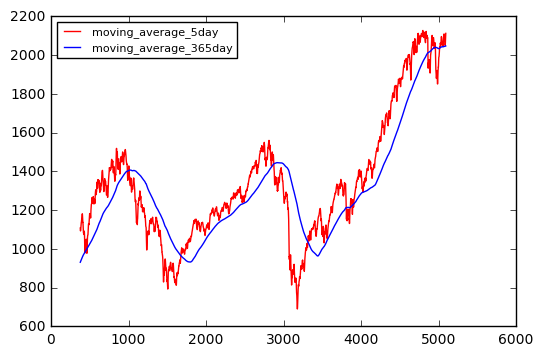

In [14]:
data_mean_5day=df['PX_OPEN'].rolling(window=5,center=False).mean()
data_mean_365day=df['PX_OPEN'].rolling(window=365,center=False).mean()
data_used_for_comparsion_365=data_mean_365day[365:len(data_mean_365day)]
data_used_for_comparsion_5=data_mean_5day[365:len(data_mean_5day)]
plt.plot(df['index'][365:len(data_mean_365day)],data_used_for_comparsion_5,c='red')
plt.plot(df['index'][365:len(data_mean_365day)],data_used_for_comparsion_365,c='blue')
plt.legend(['moving_average_5day','moving_average_365day'],loc=2,prop={'size':8})
plt.show()

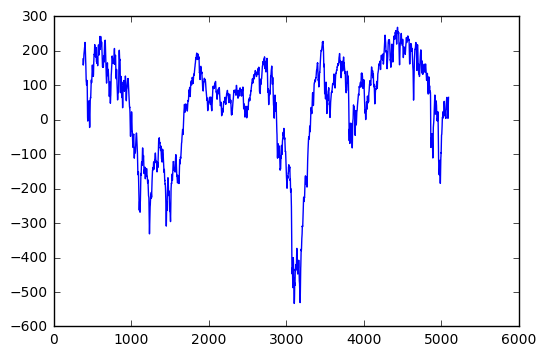

In [15]:
spread_between_5day_and_365day=data_used_for_comparsion_5-data_used_for_comparsion_365
plt.plot(spread_between_5day_and_365day.index,spread_between_5day_and_365day)
plt.show()
timespot=[x for x in spread_between_5day_and_365day.index if spread_between_5day_and_365day.loc[x]<=10 and spread_between_5day_and_365day.loc[x]>=-10]
potential_trading_chance=spread_between_5day_and_365day[timespot]
    

## Trend: Hodrick-Prescott filter

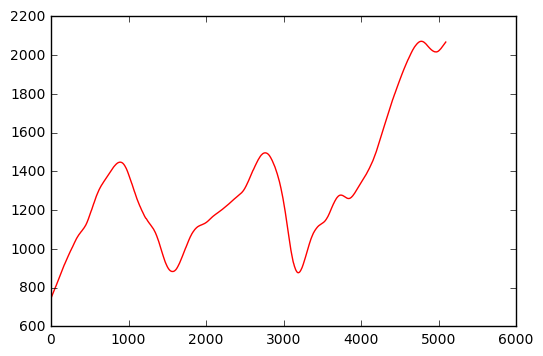

array([[  -1,    4],
       [   0, 4905],
       [   1,    5]])

In [16]:
import statsmodels.api as sm

def trend (series,lamb=12960000):
    data=series
    cycle,trend=sm.tsa.filters.hpfilter(data,lamb=lamb)
    plt.plot(df['index'],trend,c='red')
    plt.show()
    trend_array=trend.as_matrix()
    signal_trend=['Notrend']
    signal=[0]
    for k in range (1,len(trend_array)):
        if trend_array[k]-trend_array[k-1]<0:
            signal_trend.append('Downtrend')
        elif trend_array[k]-trend_array[k-1]>0:
            signal_trend.append('Uptrend')
        else:
            signal_trend.append('Notrend')
    for i1 in range (1,len(signal_trend)):
        if signal_trend[i1]=='Downtrend' and signal_trend[i1-1]!='Downtrend':
            signal.append(-1)
        elif signal_trend[i1]=='Uptrend' and signal_trend[i1-1]!='Uptrend':
            signal.append(1)
        else:
            signal.append(0)
    unique, counts=np.unique(signal,return_counts=True)
    return np.asarray((unique, counts)).T

trend(df['PX_CLOSE_1D'],12960000)

## Moving Average Indicator 

In [17]:
def sma(series, window=50, min_periods=0):
    # Center must always be False to circumvent look-ahead bias
    sma = series.rolling(window=window, min_periods=min_periods,
                         center=False).mean()
    sma.rename(index='SMA', inplace=True)
    return sma


def ema(series, window=50, min_periods=0):
    ema = series.ewm(span=window, min_periods=min_periods, adjust=False).mean()
    ema.rename(index='EMA', inplace=True)
    return ema


def macd(series, fast_window=12, slow_window=26, signal_window=9):
    dema = ema(series, window=fast_window) - ema(series, window=slow_window)
    dema_matrix=dema.as_matrix()
    signal=[0]
    for i in range (1,len(dema_matrix)):
        if dema_matrix[i]<0 and dema_matrix[i-1]/dema_matrix[i]<=0:
            signal.append(1)
        elif dema_matrix[i]>0 and dema_matrix[i-1]/dema_matrix[i]<=0:
            signal.append(-1)
        elif dema_matrix[i-1]/dema_matrix[i]>0:
            signal.append(0)
    unique, counts=np.unique(signal,return_counts=True)
    df['Signal_MACD']=signal
    return (np.asarray((unique, counts)).T)

    
macd(df['PX_CLOSE_1D'],20,50)

array([[  -1,   45],
       [   0, 4824],
       [   1,   45]])

## Stochastic 

In [44]:
def stoc(df, col_labels=('PX_LOW', 'PX_HIGH', 'PX_CLOSE_1D'),k_smooth=0, d_smooth=3, window=14, min_periods=0):
    low = df[col_labels[0]]
    high = df[col_labels[1]]
    close = df[col_labels[2]]
    lowest_low = low.rolling(window=window, min_periods=0).min()
    highest_high = high.rolling(window=window, min_periods=0).max()

    k = (close - lowest_low) / (highest_high - lowest_low) * 100

    if min_periods > 0:
        k[:min_periods] = np.NaN

    if k_smooth != 0:
        k = sma(k, window=k_smooth)
    d = sma(k, window=d_smooth)
    result=pd.DataFrame({'%K': k, '%D': d})
    signal=[0]
    result=result.reset_index(drop=True)
    for i2 in range (1,len(result)):
        if result['%K'][i2-1]<result['%D'][i2-1]<20 and result['%K'][i2]<result['%D'][i2]<80:
            signal.append(1)
        elif result['%K'][i2-1]>result['%D'][i2-1]>80 and result['%K'][i2]>result['%D'][i2]>80:
            signal.append(-1)
        else:
            signal.append(0)
    df['Signal_stoc']=signal
    unique, counts=np.unique(signal,return_counts=True)
    return (np.asarray((unique, counts)).T)


stoc(df)

array([[  -1,  283],
       [   0, 4584],
       [   1,   47]])

ImportError: No module named talib